# Unsupervised Learning Techniques for weather data

## K-Means

In [124]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp


In [125]:
from sklearn.cluster import KMeans

In [126]:
dfXy = pd.read_csv('weather_data.csv', usecols=range(8)).copy() #using X and Y variables 
dfX = pd.read_csv('weather_data.csv', usecols=range(7)).copy() #using only X variables
df_dummies = pd.get_dummies(dfXy['Condition']) #get_dummies() is applied to Y
df_with_dummies = pd.concat([dfX, df_dummies], axis=1) #using X and and Y but with dummy variables
df_with_dummies.tail()

,Temperature(°C),Dew Point(°F),Humidity(°%),Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.,Cloudy,Cloudy / Windy,Drizzle,...,Snow Shower,Snow Shower / Windy,Snow and Thunder,T-Storm,T-Storm / Windy,Thunder,Thunder / Wintry Mix,Thunder in the Vicinity,Wintry Mix,Wintry Mix / Windy
48166,9,4,71,13,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48167,9,4,71,12,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48168,9,4,71,10,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48169,9,4,71,12,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
48170,9,4,71,13,0,31,0.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [127]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_with_dummies_sc = scaler.fit_transform(df_with_dummies)

### Determination of optimum number of clusters

In [128]:
from yellowbrick.cluster import KElbowVisualizer
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,10))

Avoid warnings:

In [129]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

c:\Users\anerg\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\anerg\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


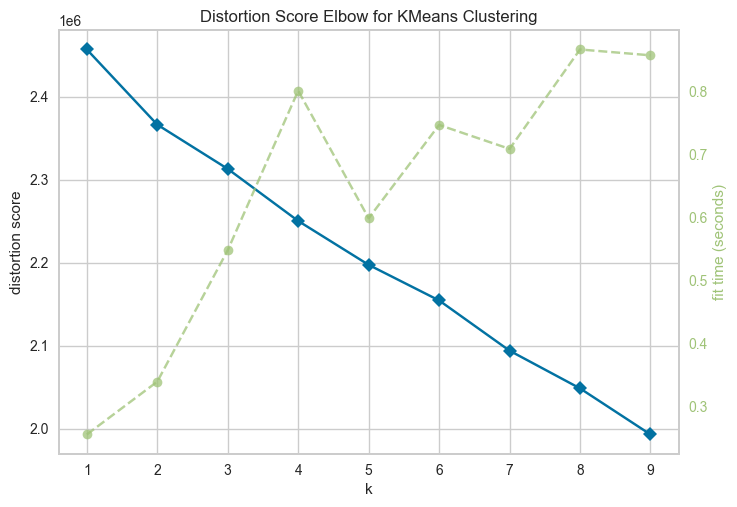

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [130]:
visualizer.fit(df_with_dummies_sc)
visualizer.poof()

Let's assume that best k = 6

In [131]:
k = 6
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state=23) #best n_clusters evaluated as 4
k_fit = kmeans.fit(df_with_dummies_sc)
dfXy['Cluster'] = kmeans.predict(df_with_dummies_sc)

cluster_mapping = {}
for i in range(k):
    # Filter dataframe to rows with cluster label i and get unique weather conditions
    conditions = dfXy.loc[dfXy['Cluster'] == i, 'Condition'].unique().tolist()
    # Add cluster label and associated weather conditions to dictionary
    cluster_mapping[i] = conditions
    print(cluster_mapping[i])


['Light Rain']
['Fair', 'Thunder', 'Light Rain with Thunder', 'Thunder in the Vicinity', 'Heavy Rain Shower', 'Heavy T-Storm']
['Mostly Cloudy / Windy', 'Light Rain Shower / Windy', 'Fair', 'Fair / Windy', 'Rain Shower / Windy', 'Partly Cloudy / Windy', 'Mostly Cloudy', 'Light Snow Shower / Windy', 'Light Snow Shower', 'Snow Shower / Windy', 'T-Storm / Windy', 'Cloudy', 'Cloudy / Windy', 'Light Rain / Windy', 'Light Rain with Thunder', 'Thunder', 'Light Drizzle / Windy', 'Wintry Mix', 'Light Snow', 'Light Snow / Windy', 'Snow Shower', 'Mist / Windy', 'Rain Shower', 'T-Storm', 'Wintry Mix / Windy', 'Light Snow with Thunder', 'Heavy Snow Shower', 'Heavy Snow with Thunder', 'Partly Cloudy']
['Light Rain Shower']
['Mostly Cloudy', 'Rain Shower', 'Cloudy', 'Rain', 'Mist', 'Light Drizzle', 'Light Rain with Thunder', 'Wintry Mix / Windy', 'Wintry Mix', 'Snow Shower', 'Heavy Snow Shower / Windy', 'Heavy Snow Shower', 'Fog', 'Drizzle', 'T-Storm', 'Light Rain / Windy', 'Patches of Fog', 'Light D

---

#### Extract outliers and try again.

In [132]:
condition_counts = dfXy.loc[:,'Condition'].value_counts()
con_counts_array = condition_counts.values
# percentile = condition_counts.sum() * 0.001
# outliers = condition_counts[condition_counts < percentile].index
# outliers
con_counts_array

array([25111, 11142,  5072,  2364,   815,   556,   505,   417,   371,
         363,   294,   162,   113,   112,   105,    87,    83,    62,
          55,    53,    47,    37,    37,    30,    29,    28,    18,
          15,    13,    12,    11,     8,     8,     7,     6,     6,
           3,     3,     3,     2,     2,     1,     1,     1,     1],
      dtype=int64)

##### Outliers detection with isoaltion forest

In [133]:
from sklearn.ensemble import IsolationForest
isofor = IsolationForest(random_state = 23).fit(con_counts_array.reshape(-1,1))
outliers = isofor.predict(con_counts_array.reshape(-1,1))
print(np.where(outliers == -1)[0])


[0 1 2 3 4]


##### Outliers detection with Z-score

In [134]:
# from scipy import stats
# z_scores = np.abs(stats.zscore(con_counts_array))
# threshold = 1
# outliers = np.where(z_scores > threshold)[0]
# print(outliers) 

"""
Output: [0 1]
eventhough threshold is assigned 1  
"""

'\nOutput: [0 1]\neventhough threshold is assigned 1  \n'

---

In [143]:
outliers = condition_counts.iloc[4:].index
# Mostly Cloudy / Windy does not sound sense suddenly
outliers

Index(['Mostly Cloudy / Windy', 'Light Rain', 'Fair / Windy', 'Mist',
       'Light Snow Shower', 'Partly Cloudy / Windy',
       'Light Rain Shower / Windy', 'Cloudy', 'Rain Shower',
       'Light Rain with Thunder', 'Light Rain / Windy', 'Wintry Mix', 'Fog',
       'Rain Shower / Windy', 'Light Snow Shower / Windy', 'Snow Shower',
       'T-Storm', 'Thunder in the Vicinity', 'Light Drizzle', 'Thunder',
       'Rain', 'Patches of Fog', 'Heavy Snow Shower', 'T-Storm / Windy',
       'Snow Shower / Windy', 'Light Snow', 'Wintry Mix / Windy',
       'Light Snow with Thunder', 'Drizzle', 'Light Snow / Windy',
       'Heavy Snow with Thunder', 'Light Drizzle / Windy',
       'Thunder / Wintry Mix', 'Heavy Snow', 'Heavy Snow Shower / Windy',
       'Mist / Windy', 'Cloudy / Windy', 'Rain / Windy', 'Snow and Thunder',
       'Heavy Rain Shower', 'Heavy T-Storm'],
      dtype='object')

In [144]:
df_no_outliers = dfXy[~dfXy['Condition'].isin(outliers)]
df_no_outliers.reset_index()

,index,Temperature(°C),Dew Point(°F),Humidity(°%),Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.,Condition,Cluster
0,0,3,2,87,3,0,31,0.0,Partly Cloudy,5
1,1,8,3,76,9,0,31,0.0,Mostly Cloudy,4
2,2,8,4,81,8,0,31,0.0,Mostly Cloudy,4
3,3,7,3,76,6,0,31,0.0,Mostly Cloudy,4
4,4,5,3,81,5,0,31,0.0,Mostly Cloudy,4
...,...,...,...,...,...,...,...,...,...,...
43684,48166,9,4,71,13,0,31,0.0,Mostly Cloudy,4
43685,48167,9,4,71,12,0,31,0.0,Fair,1
43686,48168,9,4,71,10,0,31,0.0,Fair,1
43687,48169,9,4,71,12,0,31,0.0,Fair,1


In [145]:
df_no_outliers['Condition'].value_counts()

Fair                 25111
Mostly Cloudy        11142
Partly Cloudy         5072
Light Rain Shower     2364
Name: Condition, dtype: int64

In [74]:
df_no_outliers_with_dummies = pd.get_dummies(df_no_outliers['Condition'])

In [75]:
scaler = StandardScaler()
df_no_outliers_with_dummies_sc = scaler.fit_transform(df_no_outliers_with_dummies)

c:\Users\anerg\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\utils\kneed.py:156: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
c:\Users\anerg\AppData\Local\Programs\Python\Python310\lib\site-packages\yellowbrick\cluster\elbow.py:374: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


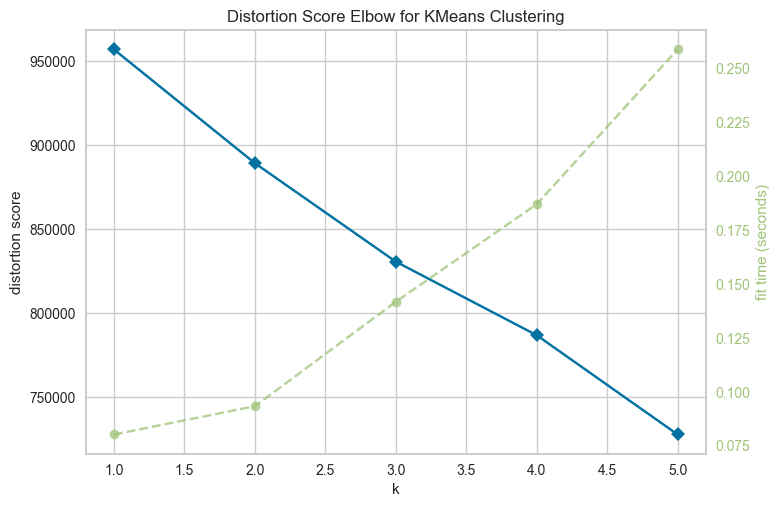

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [76]:
kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(1,6))
visualizer.fit(df_no_outliers_with_dummies_sc)
visualizer.poof()

In [80]:

k = 5
kmeans = KMeans(n_clusters=k, init = 'k-means++',random_state=23) #best n_clusters evaluated as 4
k_fit = kmeans.fit(df_no_outliers_with_dummies_sc)
df_no_outliers['Cluster'] = kmeans.predict(df_no_outliers_with_dummies_sc)

cluster_mapping = {}
for i in range(k):
    # Filter dataframe to rows with cluster label i and get unique weather conditions
    conditions = df_no_outliers.loc[df_no_outliers['Cluster'] == i, 'Condition'].unique().tolist()
    # Add cluster label and associated weather conditions to dictionary
    cluster_mapping[i] = conditions
    print(cluster_mapping[i])

['Partly Cloudy']
['Fair', 'Light Rain Shower / Windy', 'Fair / Windy', 'Rain Shower', 'Rain Shower / Windy', 'Light Rain', 'Cloudy', 'Partly Cloudy / Windy', 'Mist', 'Light Rain with Thunder', 'Light Snow Shower / Windy', 'Light Snow Shower', 'Wintry Mix', 'Snow Shower', 'Fog', 'Light Rain / Windy']
['Light Rain Shower']
['Mostly Cloudy / Windy']
['Mostly Cloudy']


C:\Users\anerg\AppData\Local\Temp\ipykernel_9372\1727605948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Cluster'] = kmeans.predict(df_no_outliers_with_dummies_sc)


----

In [109]:
kmeans = KMeans(n_clusters=4, random_state=23) #best n_clusters evaluated as 4
k_fit = kmeans.fit(df_with_dummies)
clusters = k_fit.labels_
clusters

array([3, 0, 3, ..., 0, 0, 0])

In [110]:
df_clusters = pd.DataFrame({'Clusters': clusters})
df_unsupervised = pd.concat([dfXy, df_clusters], axis=1)
df_unsupervised.iloc[:,-1].value_counts()

2    13149
3    12611
0    12486
1     9925
Name: Clusters, dtype: int64

### K-Means Model&Visualization

In [55]:
kmeans = KMeans(n_clusters=2)
k_fit = kmeans.fit(df_X)

In [56]:
k_fit.cluster_centers_

array([[19.6962762 , 10.92483354, 57.45020962, 11.18377312,  0.3988656 ,
        30.08177559,  0.        ],
       [13.50845999, 10.32692859, 81.53595498,  9.1222756 ,  0.51831804,
        30.20977918,  0.        ]])

In [57]:
k_fit.labels_

array([1, 1, 1, ..., 1, 1, 1])

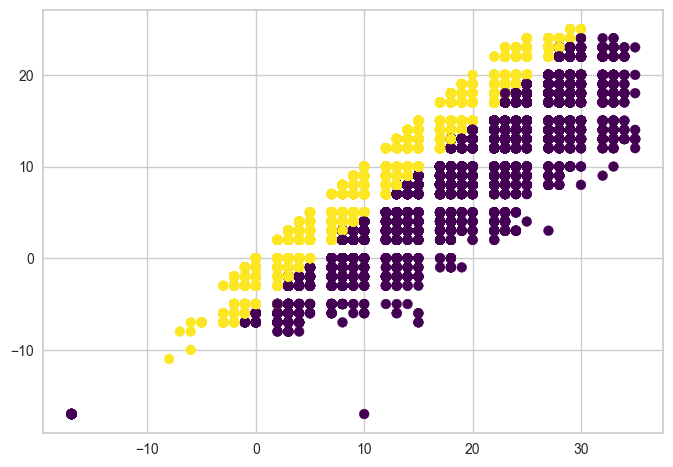

In [58]:
labels = k_fit.labels_
plt.scatter(df.iloc[:,0], df.iloc[:,1],c = labels, s = 50, cmap = 'viridis')

### Clustering Weather due to K-Means (k=4) 

In [102]:
df_org = pd.read_csv('weather_data.csv')
df_org

df_with_clusters = pd.concat([df_org, df_unsupervised.loc[:,'Clusters']], axis=1)
df_with_clusters.tail(3)

,Temperature(°C),Dew Point(°F),Humidity(°%),Wind Speed(°mph),Wind Gust(°mph),Pressure(°in),Precip.,Condition,Clusters
48168,9,4,71,10,0,31,0.0,Fair,3
48169,9,4,71,12,0,31,0.0,Fair,3
48170,9,4,71,13,0,31,0.0,Fair,3


In [103]:
df_with_clusters.to_csv('weather_data_unsupervise.csv', index= False)

In [104]:
for cluster in range(4):
    df_cluster_group = df_with_clusters.groupby('Clusters').get_group(cluster)
    print(f'\nCluster: {cluster} value counts:\n','-'*30,'\n', df_cluster_group['Condition'].value_counts())


Cluster: 0 value counts:
 ------------------------------ 
 Fair                         4091
Mostly Cloudy                3601
Light Rain Shower            1803
Partly Cloudy                 597
Light Rain                    508
Mist                          391
Light Snow Shower             297
Light Rain Shower / Windy     237
Mostly Cloudy / Windy         205
Rain Shower                   105
Cloudy                        100
Light Rain / Windy             95
Fog                            82
Wintry Mix                     81
Rain Shower / Windy            60
Snow Shower                    52
Light Rain with Thunder        47
Light Snow Shower / Windy      39
T-Storm                        32
Light Drizzle                  29
Rain                           28
Patches of Fog                 25
Heavy Snow Shower              18
T-Storm / Windy                12
Snow Shower / Windy            11
Wintry Mix / Windy             11
Drizzle                         7
Heavy Snow with Thunde

As it's observed, K-Means does not work well on this dataset. Or there could be another reason. But in my opinion, we should try hierarchical clustering which different algorithm for clustering.

## Hierarchical Clustering